### Import libraries

In [103]:
import os
import datetime as dt
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
from functools import reduce
import pandas_profiling as pp 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns;sns.set()
import reverse_geocoder as rg
random_state = np.random.seed(42) # Global random state
import warnings
warnings.filterwarnings("ignore")

### Import data

In [104]:
df=pd.read_csv('Activity_summary.csv')

### Data Wrangling

In [105]:
df.head()

,user_id,created_date,registration_date,account_closed,open-chats,open-events,open-feed,open-filters,open-main,open-meet,...,ltv,percent_property_complete,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,4230245.0,2019-07-01T00:00:00Z,2019-07-01T00:00:00Z,0,15,0,2,0,43,62,...,0,77.272727,1,1,1,1,1,1,1,1
1,4230246.0,2019-07-01T00:00:00Z,2019-07-01T00:00:00Z,0,59,0,49,0,10,52,...,0,72.727273,1,0,0,0,0,0,0,0
2,4230247.0,2019-07-01T00:00:00Z,2019-07-01T00:00:00Z,0,7,0,8,0,6,18,...,0,81.818182,1,1,0,1,0,0,0,0
3,4230248.0,2019-07-01T00:00:00Z,2019-07-01T00:00:00Z,0,0,0,0,0,1,5,...,0,9.090909,1,0,0,0,0,0,0,0
4,4230249.0,2019-07-01T00:00:00Z,2019-07-01T00:00:00Z,0,32,0,0,0,5,29,...,0,45.454545,1,1,1,1,0,0,0,0


#### Feature Engineering

In [106]:
def zip_coordinates(df):
    df['location'] = list(zip(df.lat,df.lon))
    df.drop(columns={'lat','lon'})
zip_coordinates(df)

In [107]:
coordinate_list=list(set(df['location']))
local=list(map(dict,(rg.search(coordinate_list))))

In [108]:
location_dict=dict(zip(coordinate_list,local))

In [109]:
local_1 = pd.DataFrame.from_dict(location_dict,orient='index').reset_index()
local_1.drop(columns=['lat','lon'],inplace=True)
local_1.rename(columns={'admin1':'state','admin2':'county','cc':'country_code',
                        'name':'city','level_0':'lat','level_1':'lon'},inplace=True)

In [110]:
local_1['location'] = list(zip(local_1.lat, local_1.lon))
local_1.drop(columns={'lat','lon'},inplace=True)

In [111]:
df = pd.merge(df,local_1,how='left',on='location')
df.drop(columns=['location'],inplace=True)

In [112]:
local_dict_1=(df.groupby(['city','state','country_code'])['user_id'].nunique()).to_dict()

In [113]:
try:
    df1=pd.read_csv('insight_activeAccounts_latlon_20190701_20190714.csv')
    df2=pd.read_csv('insight_activeAccounts_latlon_20190715_20190731.csv')
except:
    print('Error: File does not exist.')

In [114]:
frames=[df1,df2]
df_act=pd.concat(frames)

In [115]:
def convert_time(df_act):
    df_act['registration_date'] = pd.to_datetime(pd.to_datetime(df_act['registration_date'],unit='s').dt.date)
    df_act['active_date'] = pd.to_datetime(df_act['active_date'],unit='s')
convert_time(df_act)

In [116]:
def zip_coordinates(df_act):
    df_act['location'] = list(zip(df_act.lat,df_act.lon))
    df_act.drop(columns={'lat','lon'})
zip_coordinates(df_act)

In [117]:
df_act=df_act[(df_act.registration_date < '2019-07-01')&(df_act.status==1)]

In [118]:
df_act.drop(columns={'lat','lon','registration_date','status'},inplace=True)
df_act.rename(columns={'active_date':'registration_date'},inplace=True)

In [119]:
coordinates = list(set(df_act['location']))
location = list(map(dict,rg.search(coordinates)))

In [120]:
location_dict = dict(zip(coordinates,location))
local_2 = pd.DataFrame.from_dict(location_dict,orient='index').reset_index()
local_2.drop(columns=['lat','lon'],inplace=True)
local_2.rename(columns={'admin1':'state','admin2':'county','cc':'country_code',
                          'name':'city','level_0':'lat','level_1':'lon'},inplace=True)

In [121]:
local_2['location'] = list(zip(local_2.lat,local_2.lon))
local_2.drop(columns={'lat','lon'},inplace=True)

In [122]:
df_act=pd.merge(df_act,local_2,how='left',on='location')
df_act.drop(columns=['location'],inplace=True)

In [123]:
local_dict_2=(df_act.groupby(['city','state','country_code'])['active_user_id'].nunique()).to_dict()

In [124]:
from collections import Counter
user_local=Counter(local_dict_1) + Counter(local_dict_2)

In [125]:
df['location'] = list(zip(df['city'], df['state'],df['country_code']))
df['user_density'] = df['location'].map(user_local)

### Data Cleaning

In [126]:
df=df[(df.day_0==1)&(df.account_closed==0)&(df.status==1)&(df.login_method.isin(['FB',
                                                                          'PNL','IG']))]


In [127]:
df['age']=np.where(df['age'].isna() == True,df['age'].mode(),df['age']).astype('int')

In [128]:
def target(df):
    df['target'] = np.where((df['day_0']==1)&(df['day_1']==1),False,
                       np.where((df['day_0']==1)&(df['day_1']==0),True,None))
    df['target']=df['target'].astype('int')
target(df)

In [129]:
col=['created_date','registration_date','account_closed','status','day_0','day_1','day_2',
     'day_3','day_4','day_5','day_6','day_7','lat','lon','location','city','state','county',
     'country_code']
df.drop(col,axis=1,inplace=True)

In [130]:
df.set_index('user_id',inplace=True)

In [131]:
df[:]=np.nan_to_num(df)

In [132]:
df.fillna(0,inplace=True)

In [133]:
df[['swiped-left','percent_property_complete']]=df[['swiped-left','percent_property_complete']].astype('int')

### Initial Data Analysis

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 63204 entries, 4230245.0 to 4355524.0
Data columns (total 26 columns):
open-chats                   63204 non-null int64
open-events                  63204 non-null int64
open-feed                    63204 non-null int64
open-filters                 63204 non-null int64
open-main                    63204 non-null int64
open-meet                    63204 non-null int64
open-notifications           63204 non-null int64
open-premium-filters         63204 non-null int64
open-profile                 63204 non-null int64
swiped-left                  63204 non-null int64
swiped-right                 63204 non-null int64
convos_joined                63204 non-null int64
feed_pages                   63204 non-null int64
match_count                  63204 non-null int64
messages_sent                63204 non-null int64
n_msgs_received              63204 non-null int64
likes_received_count         63204 non-null int64
login_method               

In [135]:
df.describe()

,open-chats,open-events,open-feed,open-filters,open-main,open-meet,open-notifications,open-premium-filters,open-profile,swiped-left,...,n_msgs_received,likes_received_count,friend_count,age,push_authorized,subscription_length,ltv,percent_property_complete,user_density,target
count,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,...,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000,63204.000000
mean,12.278796,0.095975,3.765126,0.000316,3.811594,15.376369,13.581419,1.033004,9.022372,100.722644,...,7.592130,20.094235,3.223230,25.503734,0.457677,1.481235,0.962819,43.144848,145.401699,0.405196
std,29.357608,0.543618,13.250191,0.021784,6.005025,19.550634,22.998718,2.130986,20.762092,161.576602,...,24.215681,28.494492,13.729553,7.850205,0.498209,13.939246,6.181014,32.228103,327.233071,0.490934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.000000,0.000000,20.000000,0.000000,0.000000,0.000000,13.000000,9.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000,2.000000,9.000000,4.000000,0.000000,0.000000,38.000000,...,0.000000,11.000000,0.000000,23.000000,0.000000,0.000000,0.000000,36.000000,32.000000,0.000000
75%,11.000000,0.000000,3.000000,0.000000,5.000000,22.000000,17.000000,1.000000,9.000000,178.000000,...,4.000000,25.000000,2.000000,29.000000,1.000000,0.000000,0.000000,72.000000,117.000000,1.000000
max,903.000000,37.000000,699.000000,2.000000,115.000000,335.000000,517.000000,64.000000,574.000000,11732.000000,...,991.000000,832.000000,983.000000,117.000000,1.000000,365.000000,90.000000,100.000000,2243.000000,1.000000


In [136]:
num_feat=[]
def numerical_features(df):
    for c in list(df.columns):
        if (df[c].dtypes) == 'int' or (df[c].dtypes) == 'float':
            num_feat.append(c)
    return num_feat
numerical_features(df)

['open-chats',
 'open-events',
 'open-feed',
 'open-filters',
 'open-main',
 'open-meet',
 'open-notifications',
 'open-premium-filters',
 'open-profile',
 'swiped-left',
 'swiped-right',
 'convos_joined',
 'feed_pages',
 'match_count',
 'messages_sent',
 'n_msgs_received',
 'likes_received_count',
 'friend_count',
 'age',
 'push_authorized',
 'subscription_length',
 'ltv',
 'percent_property_complete',
 'user_density',
 'target']

In [137]:
def sample_normality(df,col_list):
    """
    Given a dataframe determines whether each numerical column is Gaussian 

    Ho = Assumes distribution is not Gaussian
    Ha = Assumes distribution is Gaussian

    Params:
        - df

    Returns:
        - W Statistic
        - p-value
        - Acceptance or Rejection of null hypothesis (Ho)
        - List of columns that do not have gaussian distribution

    """
    non_gauss=[]
    w_stat=[]
    # Determine if each sample of numerical feature is gaussian
    alpha = 0.05
    for f in num_feat:
        stat,p=shapiro(df[f])
        if p <= alpha: # Reject Ho -- Distribution is not normal
            non_gauss.append(f)
            w_stat.append(stat)
    # Dictionary of numerical features not gaussian and W-statistic        
    norm_dict=dict(zip(non_gauss,w_stat))
    return norm_dict
sample_normality(df,num_feat)

{'open-chats': 0.43165844678878784,
 'open-events': 0.1681123971939087,
 'open-feed': 0.2539982795715332,
 'open-filters': 0.003081202507019043,
 'open-main': 0.5934022665023804,
 'open-meet': 0.7451667785644531,
 'open-notifications': 0.6131023168563843,
 'open-premium-filters': 0.518844723701477,
 'open-profile': 0.4701378345489502,
 'swiped-left': 0.5627181529998779,
 'swiped-right': 0.3950304388999939,
 'convos_joined': 0.5976297855377197,
 'feed_pages': 0.24886876344680786,
 'match_count': 0.5499228239059448,
 'messages_sent': 0.3142048716545105,
 'n_msgs_received': 0.33169251680374146,
 'likes_received_count': 0.6367859840393066,
 'friend_count': 0.20087409019470215,
 'age': 0.8077940940856934,
 'push_authorized': 0.6342097520828247,
 'subscription_length': 0.07288902997970581,
 'ltv': 0.14497119188308716,
 'percent_property_complete': 0.9098482728004456,
 'user_density': 0.4578350782394409,
 'target': 0.6237294673919678}

In [138]:
from scipy.stats import kurtosis
from scipy.stats import skew

sk_dict={}
def skew_kurtosis(df,norm_dict):
    """
    Calculates the skewness and kurtosis of columns that were 
    identified to be non-gaussian
    
    Params: 
        - df
        - norm_dict; dictionary with keys representing non-gaussian columns

    Returns:
        - Skewness
        - Kurtosis
        
    """
    for k in list(norm_dict.keys()):
        sk_tup=tuple((skew(df[k]),kurtosis(df[k])))
    temp_dict=dict(zip(k,sk_tup))
    sk_dict.update(temp_dict)
    return sk_dict
skew_kurtosis(df,norm_dict)

{'t': 0.3862226528621782, 'a': -1.850832062416101}

### Exploratory Data Analysis

In [139]:
pp.ProfileReport(df)

Number of variables,27
Number of observations,63204
Total Missing (%),0.0%
Total size in memory,13.0 MiB
Average record size in memory,216.0 B
Numeric,22
Categorical,1
Boolean,2
Date,0
Text (Unique),0
Rejected,2


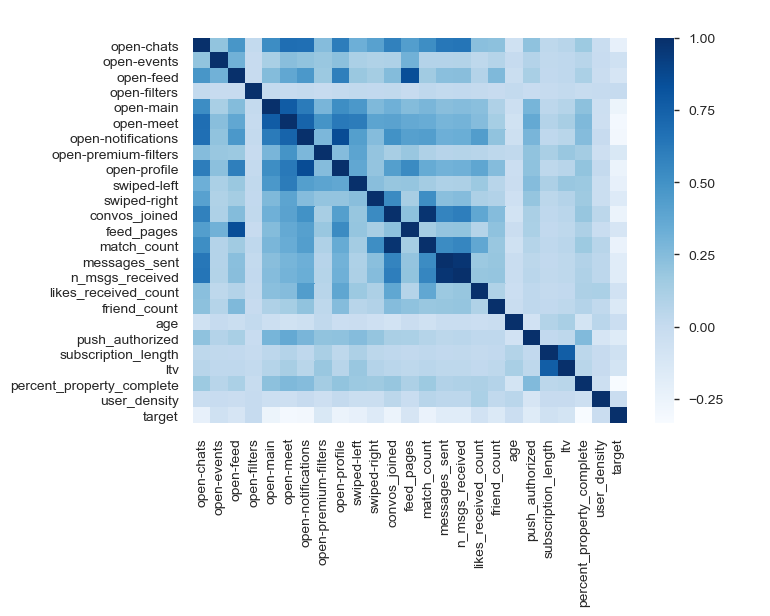

In [140]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),cmap='Blues');
plt.title('Heatmap of User Demographics and In-App Behavior',fontsize=20,fontweight='bold',color='w')
plt.tick_params(axis='both',color='w')

### Data Preprocessing

#### Categorical Variables

In [141]:
# OneHot Encoding
columns=list(df.select_dtypes('object').columns)
df=pd.get_dummies(df,columns=columns,drop_first=True)

### Feature Selection

In [142]:
from sklearn.model_selection import train_test_split
X=df.drop(columns=['target','convos_joined','n_msgs_received','open-filters'])
y=df.target.values

In [143]:
# Nonlinear Transformations
X_log=np.log(X+1)

In [144]:
X_train,X_test,y_train,y_test=train_test_split(X_log,y,
                        test_size=0.2,random_state=random_state)

### Model Fitting

In [145]:
# Logistic Regression with Recursive Feature Selection
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(solver='lbfgs',penalty='l2',C=1.0,max_iter=8000,
                      class_weight='balanced',random_state=random_state)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=8000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [146]:
# Logistic Regression
lr_pred=lr.predict(X_test)

### Test Model

In [147]:
print('Logistic Regression Train Accuracy: {:.2f}'.format(lr.score(X_train, y_train)))
print('Logistic Regression Test Accuracy: {:.2f}'.format(lr.score(X_test, y_test)))

Logistic Regression Train Accuracy: 0.76
Logistic Regression Test Accuracy: 0.77


### Cross-Validation

In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, shuffle=True, random_state=random_state)
cv_results=cross_val_score(lr,
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores

print('Average k-fold cross-validation score: {:.2}'.format(cv_results.mean()))
print('Variance in accuracy: {:.2}'.format((max(cv_results)-min(cv_results))))

Average k-fold cross-validation score: 0.73
Variance in accuracy: 0.0079


### Coefficients of Logistic Regression

In [149]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.495408
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50563
Model:                          Logit   Df Residuals:                    50540
Method:                           MLE   Df Model:                           22
Date:                Tue, 22 Oct 2019   Pseudo R-squ.:                  0.2665
Time:                        20:03:33   Log-Likelihood:                -25049.
converged:                       True   LL-Null:                       -34149.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
open-chats                    0.0154      0.023      0.667      0.505      -0.

### Model Evaluation

In [150]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
print(classification_report(y_test,lr_pred,labels=[1,0]))

              precision    recall  f1-score   support

           1       0.68      0.81      0.73      5081
           0       0.85      0.74      0.79      7560

   micro avg       0.77      0.77      0.77     12641
   macro avg       0.76      0.77      0.76     12641
weighted avg       0.78      0.77      0.77     12641



In [151]:
coef_dict={}
for coef, feat in zip(np.exp(lr.coef_[0,:]),X_train.columns):
    coef_dict[feat]=coef

In [152]:
coef_dict

{'open-chats': 1.0225434685931345,
 'open-events': 0.9392144036585949,
 'open-feed': 1.3146870966759185,
 'open-main': 0.5742414315158486,
 'open-meet': 1.7626965143124902,
 'open-notifications': 0.9249437020651234,
 'open-premium-filters': 0.8483439530616813,
 'open-profile': 0.6184628444780548,
 'swiped-left': 0.8758558583917562,
 'swiped-right': 1.0380962022882017,
 'feed_pages': 0.9284968661648695,
 'match_count': 0.5920944114461549,
 'messages_sent': 0.8143825897252057,
 'likes_received_count': 1.4749875319785377,
 'friend_count': 0.45982948005055585,
 'age': 0.40905472051458713,
 'push_authorized': 0.842866673455717,
 'subscription_length': 1.0141454116658506,
 'ltv': 0.8157842866082372,
 'percent_property_complete': 0.6211913460408389,
 'user_density': 0.9548714257293759,
 'login_method_IG': 1.0736953006959196,
 'login_method_PNL': 0.7171293577599742}

In [153]:
churn_dict={}
for churn, user in zip((lr.predict_proba(X_test)[:,1]),df.index.astype('int')):
    churn_dict[user]=churn

In [154]:
churn_dict

{4230245: 0.5783150471327397,
 4230246: 0.8003848830333873,
 4230247: 0.7247145649695622,
 4230248: 0.051006261351333876,
 4230249: 0.8999245190379055,
 4230250: 0.16419363304235718,
 4230252: 0.5766192504158191,
 4230255: 0.8442122930837668,
 4230256: 0.648798216229108,
 4230260: 0.6162315305925125,
 4230262: 0.03744512720740451,
 4230264: 0.09154506074676036,
 4230266: 0.37878253540924184,
 4230268: 0.8510874591549885,
 4230270: 0.6153178152702183,
 4230272: 0.7307128841301511,
 4230274: 0.6748094746252269,
 4230275: 0.13973839018892098,
 4230276: 0.5383145428827035,
 4230277: 0.0053897798607551945,
 4230280: 0.6242359140165575,
 4230282: 0.08293067911388594,
 4230286: 0.5479771999972828,
 4230287: 0.006777944633236349,
 4230289: 0.7991087863927364,
 4230290: 0.5762999383290551,
 4230293: 0.8700427027288403,
 4230294: 0.04082532206128141,
 4230299: 0.3520595399086996,
 4230301: 0.3454241979296475,
 4230302: 0.10064140236965138,
 4230306: 0.0563252737346368,
 4230309: 0.51100421178030

Text(0.5, 22.8611111111111, 'Predicted label\naccuracy=0.77; misclass=0.23')

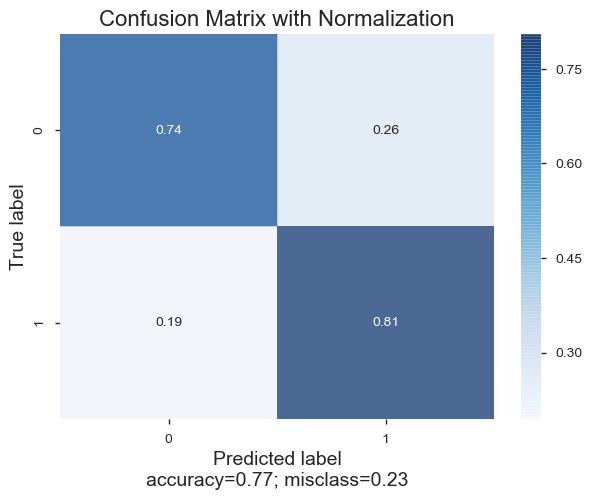

In [155]:
# Confusion Matrix
lr_matrix = confusion_matrix(y_test,lr_pred)
accuracy = np.trace(lr_matrix) / float(np.sum(lr_matrix))
misclass = 1 - accuracy
lr_matrix_sum = np.sum(lr_matrix,axis=1,keepdims=True)
lr_matrix_norm = lr_matrix/lr_matrix_sum.astype(float)

# Plot
plt.figure(figsize=(7,5))
sns.heatmap(lr_matrix_norm,annot=True,cmap="Blues",alpha=0.7)
plt.title('Confusion Matrix with Normalization',fontsize=16)
plt.ylabel('True label',fontsize=14)
plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy,misclass),fontsize=14)

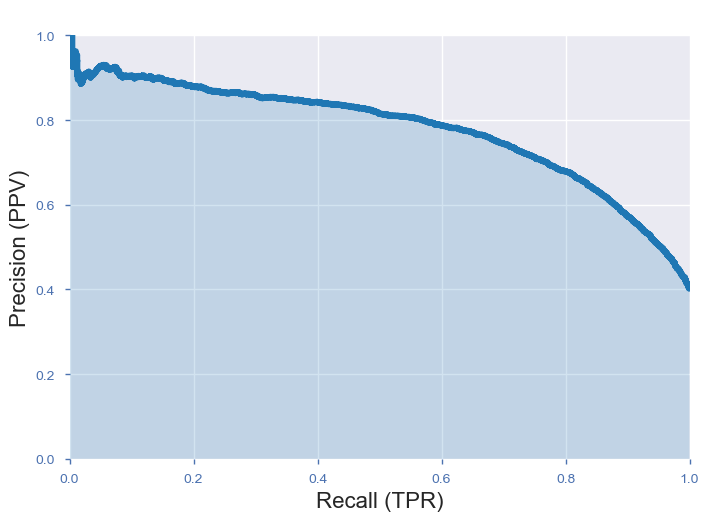

In [157]:
from sklearn.metrics import precision_recall_curve
lr_score=lr.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(
        y_test, y_score)

from inspect import signature
precision, recall, _ = precision_recall_curve(y_test, lr_score)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
with plt.rc_context({'xtick.color':'b', 'ytick.color':'b'}):
    positive_recall=0.8
    plt.step(recall, precision,where='post',linewidth=4.5)
    plt.fill_between(recall, precision, alpha=0.2, **step_kwargs)
    plt.xlabel('Recall (TPR)',fontsize=16)
    plt.ylabel('Precision (PPV)',fontsize=16)
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: Recall={0:0.2f}'.format(positive_recall),color='w',
             fontsize=18,fontweight='bold')
    plt.savefig('Recall-precision.png',transparent=True)

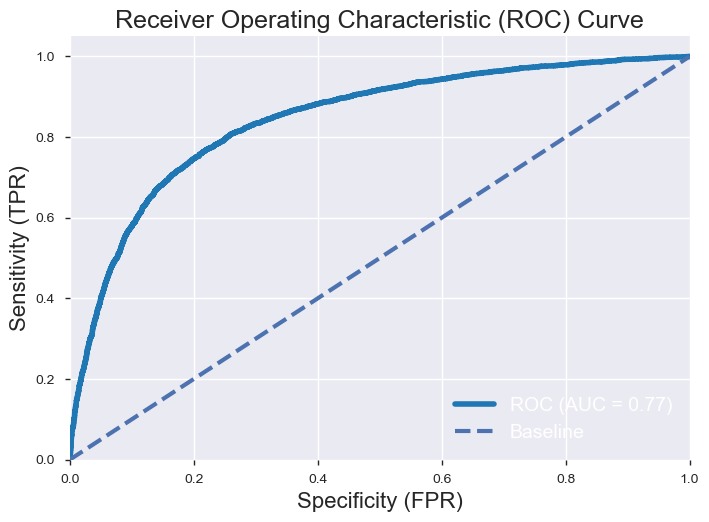

In [158]:
# Logistic Regression AUC-ROC
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, linewidth = 4,label='ROC (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'b--',linewidth=3,label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (FPR)',size=16)
plt.ylabel('Sensitivity (TPR)',size=16)
plt.title('Receiver Operating Characteristic (ROC) Curve',size=18)
l = plt.legend(loc="lower right",fontsize=14)
for text in l.get_texts():
    text.set_color("w")
plt.tick_params(axis='x')
plt.tick_params(axis='y')

### Hyperparameter Tuning

In [159]:
from sklearn.model_selection import GridSearchCV
lr=LogisticRegression(solver='saga',max_iter=10000,class_weight='balanced',
                       random_state=random_state)
grid_values = {'penalty': ['l1', 'l2'],'C':[0.1,1,5,10]}
lr_grid = GridSearchCV(lr,cv=5,param_grid=grid_values,scoring='accuracy')
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [160]:
lrc_pred=lr_grid.predict(X_test)

In [161]:
lr_grid.best_params_

{'C': 0.1, 'penalty': 'l1'}

### Model Evaluation (Post-Hyperparameter Tuning)

In [162]:
print('Logistic Regression Test Accuracy: {:.2f}'.format(lr_grid.score(X_test, y_test)))
print(classification_report(y_test,lrc_pred,labels=[1,0]))

Logistic Regression Test Accuracy: 0.77
              precision    recall  f1-score   support

           1       0.68      0.81      0.74      5081
           0       0.85      0.74      0.79      7560

   micro avg       0.77      0.77      0.77     12641
   macro avg       0.76      0.77      0.76     12641
weighted avg       0.78      0.77      0.77     12641

